# Encode IVAR of SDSS spectra

In [1]:
import os, sys 
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
import corner as DFM 
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
seed = 0 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [4]:
device

device(type='cuda', index=0)

# 1. Load measured uncertainties for SDSS Spectra
We'll be using `ivar` the inverse variance measurements

In [5]:
# read in SDSS spectra
dat_dir = '/scratch/network/chhahn/sedflow/spectra/'
rawspec = np.load(os.path.join(dat_dir, 'sdss_spectra.100000.npz')) # SDSS dr16 spectra

In [6]:
bad_ivar = (np.sum(rawspec['ivar'], axis=1) == 0)
print(f'{np.sum(bad_ivar)} have bad IVAR values')

758 have bad IVAR values


In [7]:
wave = 10**rawspec['wave']
ivar = rawspec['ivar'][~bad_ivar]
mask = rawspec['mask'][~bad_ivar]

Text(0, 0.5, 'IVAR')

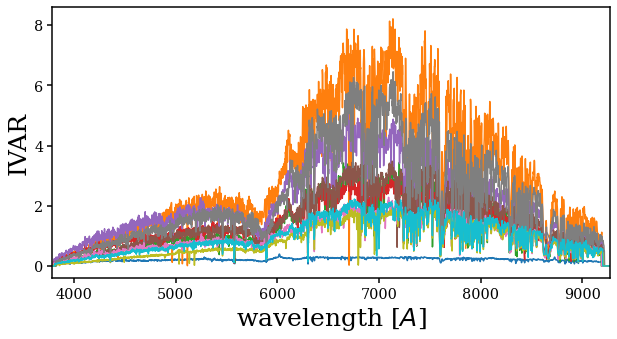

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(10): 
    sub.plot(wave[~mask[100*i]], ivar[100*i][~mask[100*i]])
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(wave[0], wave[-1])
sub.set_ylabel('IVAR', fontsize=25)

# 2. normalize and whiten ivar measurements
Before we can train an autoencoder, we probably want to normalize and whiten the data. As you can see in the figure above, the IVAR span a very broad range of amplitudes. 

The normalization factor can be one of the compressed variables

In [9]:
ivar_zero = (ivar == 0)
ivar_norm = np.array([np.median(i[~m & ~iz]) for i, m, iz in zip(ivar, mask, ivar_zero)])

In [12]:
avg_ivar = np.mean(ivar / ivar_norm[:,None], axis=0)
std_ivar = np.nanstd(ivar / ivar_norm[:,None], axis=0)

In [13]:
w_ivar = ((ivar / ivar_norm[:,None]) - avg_ivar[None,:])/std_ivar[None,:]

Text(0, 0.5, 'whitened IVAR')

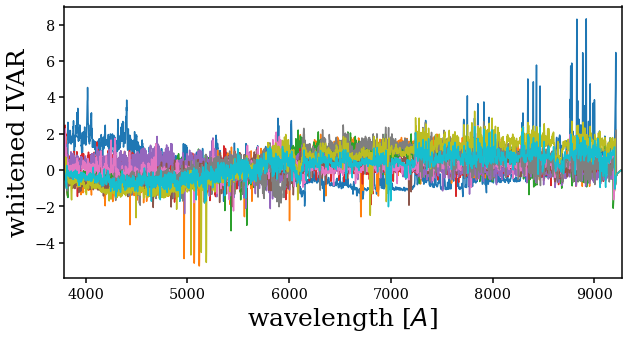

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(10): 
    sub.plot(wave[~mask[100*i]], w_ivar[100*i][~mask[100*i]])
sub.set_xlabel('wavelength [$A$]', fontsize=25)
sub.set_xlim(wave[0], wave[-1])
sub.set_ylabel('whitened IVAR', fontsize=25)

# 3. Train Autoencoder

In [18]:
batch_size = 2048

ntrain = 40000 # int(0.8 * ivar.shape[0])
nvalid = 5000 #int(0.1 * ivar.shape[0])
print(f'Ntrain = {ntrain}; Nvalid = {nvalid}')

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(w_ivar[:ntrain,:][:,None,:], dtype=torch.float32),
        torch.tensor(mask[:ntrain,:], dtype=torch.bool)),
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(w_ivar[ntrain:ntrain+nvalid,:][:,None,:], dtype=torch.float32), 
        torch.tensor(mask[ntrain:ntrain+nvalid,:], dtype=torch.bool)),
    batch_size=batch_size)

#test_dataset = torch.utils.data.TensorDataset(ivar[ntrain+nvalid:], mask[ntrain+nvalid:]),

Ntrain = 40000; Nvalid = 5000


In [19]:
class InfoVAE(nn.Module):
    def __init__(self, nwave=1000, ncode=5, alpha=0, lambd=10000, 
                 nkernels=[3, 3, 3], nhiddens_enc=[128, 64, 32], nhiddens_dec=[128, 64, 32], npools=[2, 2, 2], 
                 dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)

        nkernel0, nkernel1, nkernel2 = nkernels
        nhidden0_enc, nhidden1_enc, nhidden2_enc = nhiddens_enc
        nhidden0_dec, nhidden1_dec, nhidden2_dec = nhiddens_enc
        npool0, npool1, npool2 = npools

        # convolutional layers
        self.conv0 = nn.Conv1d(1, 1, kernel_size=nkernel0)
        Lout = nwave - nkernel0 + 1 
        self.p0 = nn.MaxPool1d(npool0)
        Lout = int((Lout - npool0)/npool0 + 1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=nkernel1)
        Lout = Lout - nkernel1 + 1 
        self.p1 = nn.MaxPool1d(npool1)
        Lout = int((Lout - npool1)/npool1 + 1)
        self.conv2 = nn.Conv1d(1, 1, kernel_size=nkernel2)
        Lout = Lout - nkernel2 + 1 
        self.p2 = nn.MaxPool1d(npool2)
        Lout = int((Lout - npool2)/npool2 + 1)

        # encoders
        self.enc0 = nn.Linear(Lout, nhidden0_enc)
        self.d1 = nn.Dropout(p=dropout)
        self.enc1 = nn.Linear(nhidden0_enc, nhidden1_enc)
        self.d2 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden1_enc, nhidden2_enc)
        self.d3 = nn.Dropout(p=dropout)

        self.mu = nn.Linear(nhidden2_enc, ncode)
        self.lv = nn.Linear(nhidden2_enc, ncode)
        
        # decoders
        self.decd = nn.Linear(ncode, nhidden2_dec)
        self.d3 = nn.Dropout(p=dropout)
        self.decd2 = nn.Linear(nhidden2_dec, nhidden1_dec)
        self.d4 = nn.Dropout(p=dropout)
        self.decd3 = nn.Linear(nhidden1_dec, nhidden0_dec)
        self.d5 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden0_dec, nwave)
        
    def encode(self, x):
        x = self.p0(F.relu(self.conv0(x)))
        x = self.p1(F.relu(self.conv1(x)))
        x = self.p2(F.relu(self.conv2(x)))
        x = self.d1(F.leaky_relu(self.enc0(x)))
        x = self.d2(F.leaky_relu(self.enc1(x)))
        x = self.d3(F.leaky_relu(self.enc2(x)))

        mu = self.mu(x)
        logvar = self.lv(x)
        return mu[:,0,:], logvar[:,0,:]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.decd2(x)))
        x = self.d5(F.leaky_relu(self.decd3(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, mask):
        recon_x, mu, logvar = self.forward(x)

        MSE = torch.sum(0.5 * ((x[:,0,:] - recon_x)[~mask]).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        device = x.device
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        true_samples = true_samples.to(device)

        z = self.reparameterize(mu, logvar) #duplicate call
        z = z.to(device)
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

--- decoder [(592, 288, 135)] ---
--- encoder [(184, 91, 18)] ---
Nwave=485 after conv.
====> Epoch: 0 TRAINING Loss: 1.10e+03 VALIDATION Loss: 1.31e+03
====> Epoch: 20 TRAINING Loss: 9.99e+02 VALIDATION Loss: 1.21e+03
====> Epoch: 40 TRAINING Loss: 9.87e+02 VALIDATION Loss: 1.19e+03
====> Epoch: 60 TRAINING Loss: 9.86e+02 VALIDATION Loss: 1.19e+03
====> Epoch: 80 TRAINING Loss: 9.86e+02 VALIDATION Loss: 1.19e+03
====> Epoch: 100 TRAINING Loss: 9.85e+02 VALIDATION Loss: 1.19e+03
====> Epoch: 120 TRAINING Loss: 9.86e+02 VALIDATION Loss: 1.19e+03


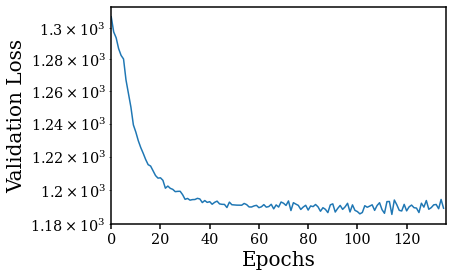

--- decoder [(1073, 306, 13)] ---
--- encoder [(870, 21, 13)] ---
Nwave=485 after conv.
====> Epoch: 0 TRAINING Loss: 1.15e+03 VALIDATION Loss: 1.33e+03
====> Epoch: 20 TRAINING Loss: 1.02e+03 VALIDATION Loss: 1.23e+03
====> Epoch: 40 TRAINING Loss: 1.01e+03 VALIDATION Loss: 1.21e+03
====> Epoch: 60 TRAINING Loss: 1.01e+03 VALIDATION Loss: 1.22e+03


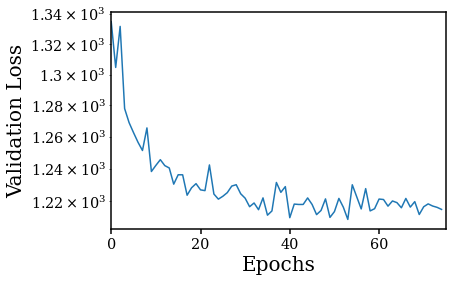

--- decoder [(2205, 1859, 1664)] ---
--- encoder [(85, 28, 22)] ---
Nwave=485 after conv.
====> Epoch: 0 TRAINING Loss: 1.52e+03 VALIDATION Loss: 1.75e+03
====> Epoch: 20 TRAINING Loss: 1.21e+03 VALIDATION Loss: 1.42e+03
====> Epoch: 40 TRAINING Loss: 1.13e+03 VALIDATION Loss: 1.34e+03
====> Epoch: 60 TRAINING Loss: 1.16e+03 VALIDATION Loss: 1.37e+03
====> Epoch: 80 TRAINING Loss: 1.13e+03 VALIDATION Loss: 1.31e+03


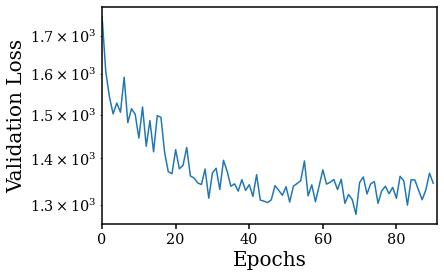

--- decoder [(652, 182, 23)] ---
--- encoder [(405, 312, 251)] ---
Nwave=485 after conv.
====> Epoch: 0 TRAINING Loss: 1.09e+03 VALIDATION Loss: 1.29e+03
====> Epoch: 20 TRAINING Loss: 9.83e+02 VALIDATION Loss: 1.19e+03
====> Epoch: 40 TRAINING Loss: 6.60e+02 VALIDATION Loss: 7.89e+02
====> Epoch: 60 TRAINING Loss: 4.58e+02 VALIDATION Loss: 5.51e+02
====> Epoch: 80 TRAINING Loss: 3.86e+02 VALIDATION Loss: 4.67e+02
====> Epoch: 100 TRAINING Loss: 3.42e+02 VALIDATION Loss: 4.42e+02
====> Epoch: 120 TRAINING Loss: 3.34e+02 VALIDATION Loss: 4.37e+02
====> Epoch: 140 TRAINING Loss: 3.26e+02 VALIDATION Loss: 4.28e+02
====> Epoch: 160 TRAINING Loss: 3.05e+02 VALIDATION Loss: 4.13e+02
====> Epoch: 180 TRAINING Loss: 2.97e+02 VALIDATION Loss: 3.99e+02
====> Epoch: 200 TRAINING Loss: 2.90e+02 VALIDATION Loss: 3.96e+02
====> Epoch: 220 TRAINING Loss: 2.84e+02 VALIDATION Loss: 3.95e+02
====> Epoch: 240 TRAINING Loss: 2.80e+02 VALIDATION Loss: 3.95e+02
====> Epoch: 260 TRAINING Loss: 2.73e+02 VALID

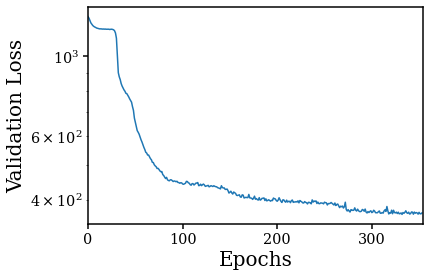

--- decoder [(4702, 306, 266)] ---
--- encoder [(197, 74, 29)] ---
Nwave=485 after conv.
====> Epoch: 0 TRAINING Loss: 1.15e+03 VALIDATION Loss: 1.36e+03
====> Epoch: 20 TRAINING Loss: 1.04e+03 VALIDATION Loss: 1.23e+03
====> Epoch: 40 TRAINING Loss: 1.03e+03 VALIDATION Loss: 1.24e+03
====> Epoch: 60 TRAINING Loss: 1.02e+03 VALIDATION Loss: 1.23e+03


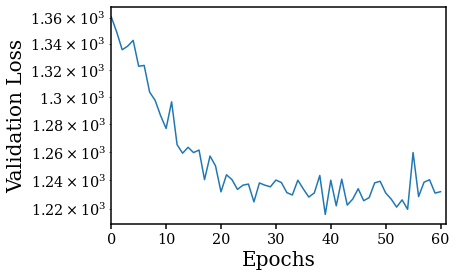

In [61]:
nwave = len(wave)
lr = 1e-3
n_epoch = 1000
nlatent = 5
dropout = 0

for i in range(5,10): 
    lambd = np.exp(np.random.uniform(0, np.log(1e5)))
    
    nhidden0 = int(np.ceil(np.exp(np.random.uniform(np.log(200), np.log(2*nwave)))))
    nhidden1 = int(np.ceil(np.exp(np.random.uniform(np.log(100), np.log(nhidden0)))))
    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(nlatent+1), np.log(nhidden1)))))
    print(f'--- decoder [{nhidden0, nhidden1, nhidden2}] ---')

    nkernels = [2,2,2]
    npools = [2,2,2]
    Nout = nwave - nkernels[0] + 1 
    Nout = int((Nout - npools[0])/npools[0] + 1)
    Nout = Nout - nkernels[1] + 1
    Nout = int((Nout - npools[1])/npools[1] + 1)
    Nout = Nout - nkernels[2] + 1
    Nout = int((Nout - npools[2])/npools[2] + 1)

    nhidden0_enc = int(np.ceil(np.exp(np.random.uniform(np.log(32), np.log(2*Nout)))))
    nhidden1_enc = int(np.ceil(np.exp(np.random.uniform(np.log(16), np.log(nhidden0_enc)))))
    nhidden2_enc = int(np.ceil(np.exp(np.random.uniform(np.log(nlatent+1), np.log(nhidden1_enc)))))
    print(f'--- encoder [{nhidden0_enc, nhidden1_enc, nhidden2_enc}] ---')  
    
    model = InfoVAE(
        alpha=0, 
        lambd=lambd, 
        nwave=nwave, 
        nkernels=nkernels, 
        npools=npools,
        nhiddens_enc=[nhidden0_enc, nhidden1_enc, nhidden2_enc], 
        nhiddens_dec=[nhidden0, nhidden1, nhidden2],
        ncode=5, 
        dropout=dropout)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=n_epoch)

    best_valid_loss, best_epoch = 1e10, 0
    
    losses = []
    for epoch in range(n_epoch):
        model.train()
        train_loss = 0.
        for batch in train_loader:
            _ivar, _mask = batch
            _ivar = _ivar.to(device)
            _mask = _mask.to(device)
            
            optimizer.zero_grad()
            loss, _, _, _ = model.loss(_ivar, _mask)
            
            loss.backward()
            train_loss += loss.item() 
            optimizer.step()
        train_loss /= len(train_loader.dataset)
    
        with torch.no_grad():
            model.eval()
            valid_loss = 0.
            for batch in valid_loader:
                _ivar, _mask = batch
                _ivar = _ivar.to(device)
                _mask = _mask.to(device)
                
                loss, _, _, _ = model.loss(_ivar, _mask)
                valid_loss += loss.item()
            valid_loss /= len(valid_loader.dataset)

        scheduler.step()
        losses.append((train_loss, valid_loss))

        if epoch % 20 == 0 or epoch == n_epoch - 1:           
            print('====> Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % (epoch, train_loss, valid_loss))

        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_epoch = epoch
        else: 
            if epoch > best_epoch + 20: 
                break 

    # plot validation loss
    plt.plot(np.array(losses)[:,1])
    plt.yscale('log')
    plt.xlabel('Epochs', fontsize=20)
    plt.xlim(0, len(losses))
    plt.ylabel('Validation Loss', fontsize=20)
    plt.show()
    
    # save model to file 
    fmodel = os.path.join(dat_dir, f'ivar.vae_model.{i}.pt')
    torch.save(model.state_dict(), fmodel) 
    
    # save training/validation loss
    floss = os.path.join(dat_dir, f'ivar.vae_model.{i}.loss.npy')
    np.save(floss, np.array(losses))

select best model 

In [63]:
models, valid_losses = [], []
for i in range(10): 
    fmodel = os.path.join(dat_dir, f'ivar.vae_model.{i}.pt')
    state_dict = torch.load(fmodel) 
    
    model = InfoVAE(alpha=0, lambd=0, # these don't matter here
                    nwave=nwave,  
                    ncode=nlatent, 
                    nkernels=[state_dict['conv0.weight'].shape[-1], state_dict['conv1.weight'].shape[-1], state_dict['conv2.weight'].shape[-1]],
                    nhiddens_enc=[state_dict['enc0.weight'].shape[0], state_dict['enc1.weight'].shape[0], state_dict['enc2.weight'].shape[0]], 
                    nhiddens_dec=[state_dict['decd.weight'].shape[0], state_dict['decd2.weight'].shape[0], state_dict['decd3.weight'].shape[0]], 
                    dropout=dropout)
    model.load_state_dict(torch.load(fmodel))
    models.append(model)

    floss = os.path.join(dat_dir, f'ivar.vae_model.{i}.loss.npy')
    valid_losses.append(np.load(floss)[:,1])

Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.
Nwave=485 after conv.


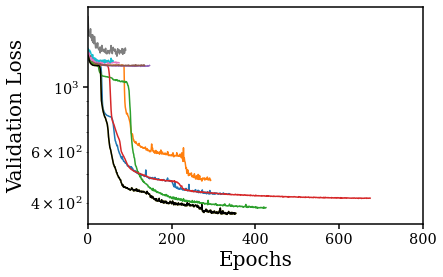

In [64]:
final_losses = np.array([_losses[-1] for _losses in valid_losses])
i_best = np.arange(len(final_losses))[np.isfinite(final_losses)][np.argmin(final_losses[np.isfinite(final_losses)])]

best_model = models[i_best]
best_model.to(device)

# plot validation losses
for _losses in valid_losses: 
    plt.plot(_losses)
plt.plot(valid_losses[i_best], c='k')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=20)
plt.xlim(0, 800)
plt.ylabel('Validation Loss', fontsize=20)
plt.show()

# 4. Validate best autoencoder

In [65]:
w_ivar_recon, _, _ = best_model.forward(torch.tensor(w_ivar[ntrain+nvalid:ntrain+nvalid+1000,None,:], dtype=torch.float32).to(device))

ivar_recon = (w_ivar_recon.detach().cpu().numpy() * std_ivar + avg_ivar) * ivar_norm[ntrain+nvalid:ntrain+nvalid+1000][:,None]

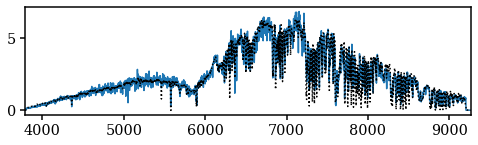

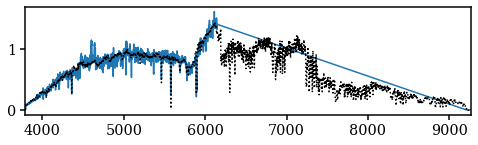

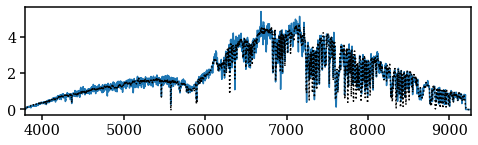

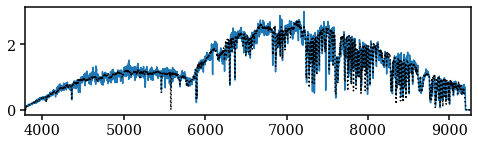

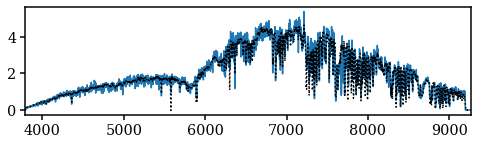

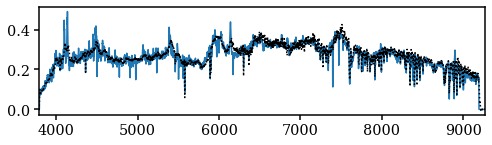

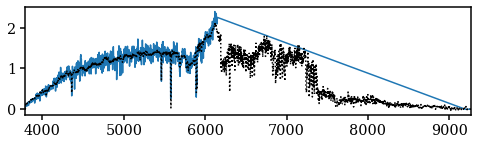

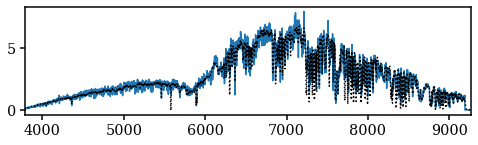

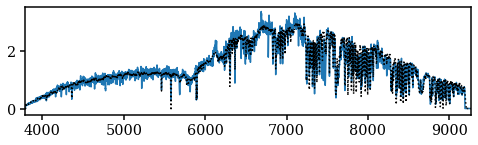

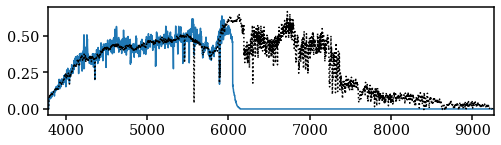

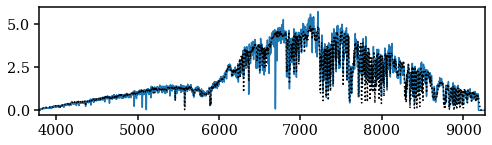

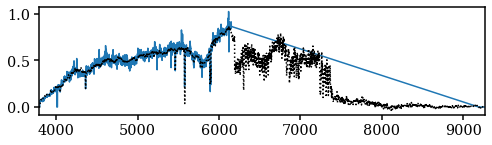

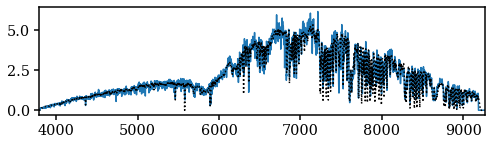

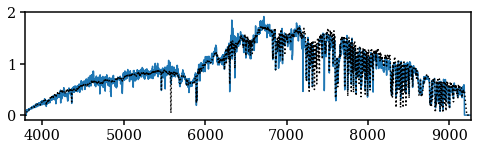

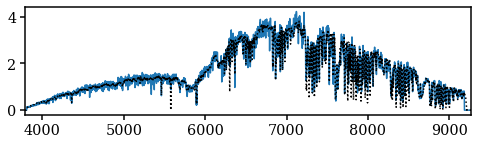

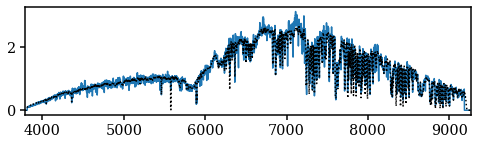

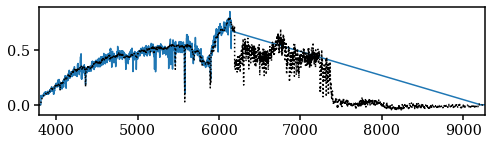

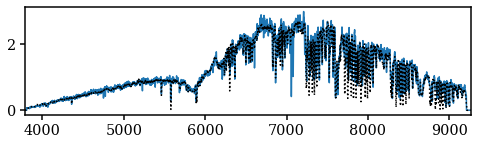

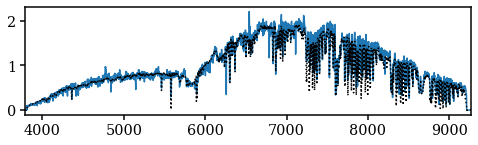

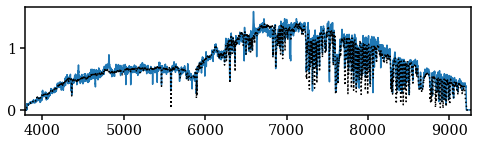

In [66]:
for i in range(20): 
    fig = plt.figure(figsize=(8,2))
    sub = fig.add_subplot(111)
    
    _mask = mask[ntrain+nvalid + 10 * i]
    sub.plot(wave[~_mask], ivar[ntrain+nvalid + 10 * i][~_mask])
    sub.plot(wave, ivar_recon[10 * i], c='k', ls=':')

    sub.set_xlim(wave[0], wave[-1])
    plt.show()

# 5. Compressed latent-space

In [67]:
_mu, _logvar = best_model.encode(torch.tensor(w_ivar[ntrain+nvalid:ntrain+nvalid+10000,None,:], dtype=torch.float32).to(device))
z = best_model.reparameterize(_mu, _logvar).cpu().detach().numpy()

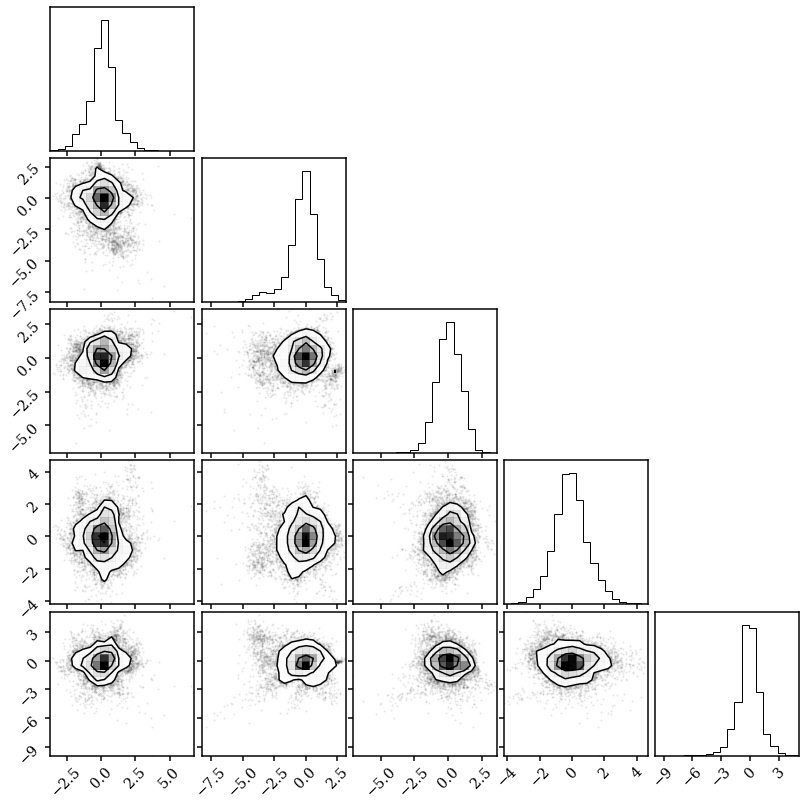

In [68]:
fig = DFM.corner(z)